In [51]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.utils.data as data_utils

if torch.cuda.is_available():
  device = "cuda" 
else:
  device = "cpu"
device_ = torch.device(device)
print(device, " in use")

torch.autograd.set_detect_anomaly(True)

cuda  in use


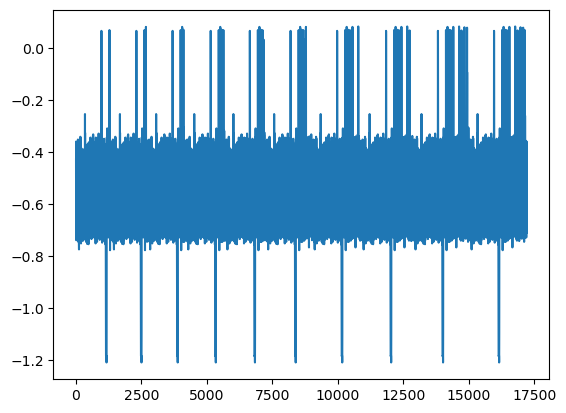

In [52]:
#states_1 = np.load('data_1.npy')
#states_2 = np.load('data_2.npy')
#states_3 = np.load('data_3.npy')
#states_4 = np.load('data_4.npy')

states_5 = np.load('data_2_025_1.npy')
states_6 = np.load('data_2_025_2.npy')
states_7 = np.load('data_2_025_3.npy')
states_8 = np.load('data_2_025_4.npy')
states_9 = np.load('data_2_025_5.npy')
states_10 = np.load('data_2_025_6.npy')
states_11 = np.load('data_2_025_7.npy')
states_12 = np.load('data_2_025_8.npy')
states_13 = np.load('data_2_025_9.npy')
states_14 = np.load('data_2_025_10.npy')


#states = np.concatenate((states_1, states_2, states_3, states_4, states_5, states_6, states_7, states_8, states_9, states_10, states_11, states_12, states_13, states_14), axis=0)
states = np.concatenate(( states_5, states_6, states_7, states_8, states_9, states_10, states_11, states_12, states_13, states_14), axis=0)

# print the array
plt.plot([row[3] for row in states])

In [53]:
obs_space = len(states[0])
obs_space

10

# Attempt 2
RNN based simple model which will take state and precit next state. loss function is how good predictions are wrt collected dataset

# Dataloader

In [54]:
# Define the dataset class
class Dataset(data_utils.Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        x = self.data[index, :]
        y = self.data[index + 1, :]
        return x, y

    def __len__(self):
        return 10

In [55]:
states = Dataset(states)

# Create a DataLoader object for the dataset
batch_size = 1
shuffle = False
dataloader = data_utils.DataLoader(states, batch_size=batch_size, shuffle=shuffle)


In [56]:
min_values = torch.tensor([-0.37, -1.53, -0.09, -1.18, -0.39 , -0.79, -1.53, -0.10, -1.18, -0.76], dtype=torch.float32)
max_values = torch.tensor([ 0.79, 0.48, 2.11, 0.92, 0.76,  0.37, 0.48, 2.12, 0.93, 0.39], dtype=torch.float32)

# Model

In [57]:
# class ActorNet(nn.Module):
#     def __init__(self, state_dim):
#         super(ActorNet, self).__init__()
#         self.num_layers = 1
#         self.hidden_dim = 128
#         self.rnn = nn.RNN(input_size=state_dim, hidden_size=self.hidden_dim, num_layers= self.num_layers, batch_first=True)
#         self.fc = nn.Linear(128, state_dim)

#     def forward(self, state):
#         # x has shape (batch_size, seq_len, input_dim)
#         batch_size = 8
        
#         # Initialize hidden state
#         h0 = torch.zeros( state.size(0), self.hidden_dim)

#         print(h0.squeeze(1).shape)
#         print(state.shape)
        
#         # Feed input through RNN
#         out, _ = self.rnn(state, h0.squeeze(1))
        
#         # Apply fully connected layer
#         out = self.fc(out)
        
#         return out
    

class ActorNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ActorNet, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        #out = out[:, -1, :]
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [58]:
Actor = ActorNet(obs_space, 10, obs_space ).to(device)

lr = 0.0001
Actor_optim = optim.Adam(Actor.parameters(), lr = lr)

criterion = nn.MSELoss()

# Train

In [67]:
running_loss = 0.0
Actor.train()
for epoch in range(5000):
    running_loss = 0.0
    for i, (x, y) in enumerate(dataloader):
        Actor_optim.zero_grad()
        
        x_clamped = torch.clamp(x, min_values, max_values)
        y_pred = Actor(x_clamped.to(device).float())


        loss = criterion(y_pred, y.to(device).float())

        loss.backward()

        Actor_optim.step()

        running_loss += loss.item()
    
    if (epoch)%100 == 0:
        print(f"Epoch {epoch}, loss: {running_loss/len(dataloader)}")
    



Epoch 0, loss: 0.0014336507359985263
Epoch 100, loss: 0.001397541539336089
Epoch 200, loss: 0.001361020041804295
Epoch 300, loss: 0.0013243585606687702
Epoch 400, loss: 0.001287880250310991
Epoch 500, loss: 0.0012519361829617993
Epoch 600, loss: 0.0012168988963821904
Epoch 700, loss: 0.0011831496667582542
Epoch 800, loss: 0.001151043896243209
Epoch 900, loss: 0.001120895313215442
Epoch 1000, loss: 0.0010929505759122548
Epoch 1100, loss: 0.0010673624830815243
Epoch 1200, loss: 0.001044193629786605
Epoch 1300, loss: 0.001023400946360198
Epoch 1400, loss: 0.0010048573207313894
Epoch 1500, loss: 0.0009883590762910898
Epoch 1600, loss: 0.0009736670477650478
Epoch 1700, loss: 0.0009605197914424934
Epoch 1800, loss: 0.0009486624945566291
Epoch 1900, loss: 0.0009378616958201746
Epoch 2000, loss: 0.0009279127692934708
Epoch 2100, loss: 0.0009186472107103327
Epoch 2200, loss: 0.0009099251237785211
Epoch 2300, loss: 0.0009016377516672947
Epoch 2400, loss: 0.0008936960370192537
Epoch 2500, loss: 0

In [60]:
x = torch.tensor([ 0.07674193, -0.4862361 ,  0.91115403, -0.41728997, -0.078192  ,
         0.09514999, -0.21940398,  0.84220791, -0.61355805, -0.09046412]).to(device)
x = x.view(1,10)
Actor(x)

tensor([[-0.0567, -0.4370,  0.9245, -0.4929,  0.1021, -0.1004, -0.4324,  1.2070,
         -0.7883,  0.1124]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Evaluate

In [61]:
eval_states = np.load('data_5.npy')
eval_states = Dataset(eval_states)

dataloader = data_utils.DataLoader(eval_states, batch_size=batch_size, shuffle=shuffle)

In [68]:
Actor.eval()

total_loss = 0.0
num_correct = 0

with torch.no_grad():
    for states, next_state in dataloader:
        next_state_pred = Actor(states.to(device).float())
        loss = criterion(next_state_pred, next_state.to(device).float())
        total_loss += loss.item() * len(states)
        
avg_loss = total_loss / len(dataloader)

print(f"Average loss: {avg_loss:.4f}")


Average loss: 0.0007


# Save Model

In [39]:
torch.save(Actor.state_dict(), 'model_weights_day3_1.pth')